In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
# e11 analysis
from e11 import H5Data, H5Scan, statistics, run_dire, run_file

# Caching

Data files can be very large and processing them can take a long time.  However, the processing results can be cached to speed up future access.

To enable caching, specify an `out_dire` when creating the instance of `H5Scan` or `H5Data`.

In [2]:
fil = os.path.join(os.getcwd(), 'example_data', 'array_data.h5')
data = H5Data(fil, out_dire='analysis')

If `out_dire` is specified then `cache_dire` is created as a sub directory of it.

In [3]:
print(data.cache_dire)

C:\Users\Adam\Documents\Git\e11_analysis\notebooks\example_data\analysis\cache


## `log()`

The first time that an instance of `H5Data(fil)` is created the log will be cached as `[cache_dire]/log.feather`.

An update of the log can be forced at any time using the method `H5Data.update_log()`.

In [4]:
# update log
%time data.update_log(cache=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2006.04it/s]


Wall time: 17 ms


In [7]:
# also update cached version (default behaviour)
%time data.update_log(cache=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2006.04it/s]


Wall time: 15 ms


In [9]:
# read log from cache
%time data.load_log()

Wall time: 2.98 ms


,ACQUIRE,DATETIME,END,ERROR,LOOP,OVERRIDE,START,VAR:PAUSE
squid,,,,,,,,
1,10.036975,2017-12-01 15:41:22,3.594988e+09,0,1,0,3.594988e+09,300
2,10.021719,2017-12-01 15:41:33,3.594988e+09,0,1,0,3.594988e+09,600
3,10.034403,2017-12-01 15:41:45,3.594988e+09,0,1,0,3.594988e+09,900
4,10.022052,2017-12-01 15:41:55,3.594988e+09,0,2,0,3.594988e+09,300
5,10.027435,2017-12-01 15:42:06,3.594988e+09,0,2,0,3.594988e+09,600
6,10.027131,2017-12-01 15:42:18,3.594988e+09,0,2,0,3.594988e+09,900


In [10]:
data.log_file

'C:\\Users\\Adam\\Documents\\Git\\e11_analysis\\notebooks\\example_data\\analysis\\cache\\log.feather'

In [12]:
# explicit read
import pyarrow.feather as feather
%time feather.read_feather(data.log_file).set_index("squid")

Wall time: 2.99 ms


,ACQUIRE,DATETIME,END,ERROR,LOOP,OVERRIDE,START,VAR:PAUSE
squid,,,,,,,,
1,10.036975,2017-12-01 15:41:22,3.594988e+09,0,1,0,3.594988e+09,300
2,10.021719,2017-12-01 15:41:33,3.594988e+09,0,1,0,3.594988e+09,600
3,10.034403,2017-12-01 15:41:45,3.594988e+09,0,1,0,3.594988e+09,900
4,10.022052,2017-12-01 15:41:55,3.594988e+09,0,2,0,3.594988e+09,300
5,10.027435,2017-12-01 15:42:06,3.594988e+09,0,2,0,3.594988e+09,600
6,10.027131,2017-12-01 15:42:18,3.594988e+09,0,2,0,3.594988e+09,900


## `array()`, `df()` and `apply()`

Caching is also available for the methods: `array()`, `df()`, and `apply()`. It is enabled by setting the name of the `cache`.

This pickles the python objects with a dictionary of metadata (will probably switch to a more portable format in future).

In [13]:
# First call of data.df(). Data is read from the hdf5 file.
%time av = data.df(data.squids, 'AV_0', ignore_missing=False, \
                   cache="av_0", update_cache=True)
av.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 376.00it/s]


Wall time: 30.9 ms


AB        CD        EF
squid measurement                              
1     0            0.983765  0.984008  0.004351
      1            0.984163  0.984424  0.004799
      2            0.983991  0.984383  0.004606
      3            0.983983  0.984222  0.004568
      4            0.983856  0.984048  0.004349

Future calls of same method with the same cache name will return the cached result.

In [14]:
# Next call of data.df(). Data is loaded from the cache (quicker).
%time av = data.df(data.squids, 'AV_0', ignore_missing=False, \
                   cache="av_0")
av.head()

Wall time: 2.97 ms


AB        CD        EF
squid measurement                              
1     0            0.983765  0.984008  0.004351
      1            0.984163  0.984424  0.004799
      2            0.983991  0.984383  0.004606
      3            0.983983  0.984222  0.004568
      4            0.983856  0.984048  0.004349

 To force an overwrite of an existing cache, call the method with  `update_cache=True`.

In [15]:
%time av, info = data.df(data.squids, 'AV_0', ignore_missing=False, \
                         cache="av_0", get_info=True, update_cache=True)
av.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 546.90it/s]


Wall time: 25.9 ms


AB        CD        EF
squid measurement                              
1     0            0.983765  0.984008  0.004351
      1            0.984163  0.984424  0.004799
      2            0.983991  0.984383  0.004606
      3            0.983983  0.984222  0.004568
      4            0.983856  0.984048  0.004349

With `get_info=True`, the metadata about the method call (e.g., args and kwargs values) are also returned.

In [16]:
pprint(info)

{'cache': 'C:\\Users\\Adam\\Documents\\Git\\e11_analysis\\notebooks\\example_data\\analysis\\cache\\av_0.df.pkl',
 'dataset': 'AV_0',
 'datetime': '2019-08-14 13:51:09',
 'ignore_missing': False,
 'method': 'df',
 'self': 'H5Data',
 'squids': array([1, 2, 3, 4, 5, 6])}


## cache location

Rather than using `H5Data.cache_dire`, it's possible to set an absolute path for the cache name. E.g.,

In [17]:
cache_file = os.path.join(os.path.expanduser("~"), 'test.pkl')
av = data.df(data.squids, 'AV_0', ignore_missing=False, cache=cache_file)
av.head()

AB        CD        EF
squid measurement                              
1     0            0.983765  0.984008  0.004351
      1            0.984163  0.984424  0.004799
      2            0.983991  0.984383  0.004606
      3            0.983983  0.984222  0.004568
      4            0.983856  0.984048  0.004349

Or explicitly set the `cache_dire` instead.

In [18]:
dire = os.path.expanduser("~")
av = data.df(data.squids, 'AV_0', ignore_missing=False, cache_dire=dire, cache='test2.pkl')
av.head()

AB        CD        EF
squid measurement                              
1     0            0.983765  0.984008  0.004351
      1            0.984163  0.984424  0.004799
      2            0.983991  0.984383  0.004606
      3            0.983983  0.984222  0.004568
      4            0.983856  0.984048  0.004349

## access the cache

Reading from the cache is automatic for calls of a compatible method with an existing cache file.  However, cache files are simply a pickle of the method result, and can be read manually.

To read the contents of the cache directory,

In [19]:
from e11.tools import ls

In [20]:
fils = ls(data.cache_dire, regex="*.df.pkl")
pprint(fils)

['C:\\Users\\Adam\\Documents\\Git\\e11_analysis\\notebooks\\example_data\\analysis\\cache\\av_0.df.pkl']


In [21]:
%time result, info = pd.read_pickle(fils[0])
pprint(info)

Wall time: 2 ms
{'dataset': 'AV_0',
 'datetime': '2019-08-14 13:51:09',
 'ignore_missing': False,
 'method': 'df',
 'self': 'H5Data',
 'squids': array([1, 2, 3, 4, 5, 6])}


In [22]:
result.head()

AB        CD        EF
squid measurement                              
1     0            0.983765  0.984008  0.004351
      1            0.984163  0.984424  0.004799
      2            0.983991  0.984383  0.004606
      3            0.983983  0.984222  0.004568
      4            0.983856  0.984048  0.004349

Actually, saving / recalling any python object to / from the cache is pretty trivial.

In [23]:
stats = statistics(av, groupby="squid")
stats.head()

AB                                  CD                                \
      count       err      mean       std count       err      mean       std   
squid                                                                           
1        25  0.000044  0.983988  0.000221    25  0.000055  0.984273  0.000276   
2        25  0.000059  0.984423  0.000297    25  0.000058  0.984697  0.000289   
3        26  0.000044  0.984914  0.000225    26  0.000052  0.985240  0.000266   
4        25  0.000074  0.984682  0.000370    25  0.000082  0.984966  0.000409   
5        25  0.000077  0.984261  0.000385    25  0.000079  0.984565  0.000393   

         EF                                
      count       err      mean       std  
squid                                      
1        25  0.000043  0.004603  0.000214  
2        25  0.000043  0.004871  0.000216  
3        26  0.000049  0.004922  0.000251  
4        25  0.000063  0.004794  0.000316  
5        25  0.000060  0.004731  0.000302

In [24]:
fname = "stats.pkl"
fil = os.path.join(data.cache_dire, fname)
pd.to_pickle(stats, fil)

In [25]:
pd.read_pickle(fil).head()

AB                                  CD                                \
      count       err      mean       std count       err      mean       std   
squid                                                                           
1        25  0.000044  0.983988  0.000221    25  0.000055  0.984273  0.000276   
2        25  0.000059  0.984423  0.000297    25  0.000058  0.984697  0.000289   
3        26  0.000044  0.984914  0.000225    26  0.000052  0.985240  0.000266   
4        25  0.000074  0.984682  0.000370    25  0.000082  0.984966  0.000409   
5        25  0.000077  0.984261  0.000385    25  0.000079  0.984565  0.000393   

         EF                                
      count       err      mean       std  
squid                                      
1        25  0.000043  0.004603  0.000214  
2        25  0.000043  0.004871  0.000216  
3        26  0.000049  0.004922  0.000251  
4        25  0.000063  0.004794  0.000316  
5        25  0.000060  0.004731  0.000302

# Saving to out_dire

`H5Data.out_dire` or `H5Scan.out_dire` is also useful for saving files that are related to the data, e.g., analysis results, notebooks or plots.

To build paths to sub-directories of `out_dire` use the function `e11_tools.sub_dire()`.

In [26]:
from e11.tools import sub_dire

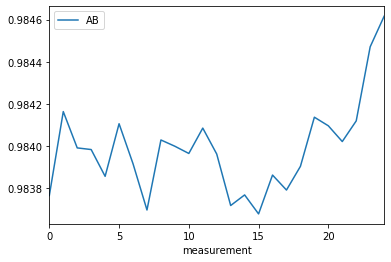

In [27]:
fig, ax = plt.subplots()

result.loc[1].plot(y="AB", ax=ax)

# output
fil = sub_dire(data.out_dire, 'plots', fname='signal.png')
plt.savefig(fil, bbox_inches="tight", dpi=300)
plt.show()

In [28]:
# export notebook
fil = sub_dire(data.out_dire, "notebooks", "caching.ipynb")
%notebook $fil

# Remote data, local cache

You may use a remote server for your data but wish to use local storage for the cache.  E.g., for the fastest possible access to the cache, or because you don't have write access to the remote server.

Assuming you have a run_id data structure:

In [29]:
# data
remote = r"Q:\E11_atmos\scan_data"
rid = "20190307_007"
fil = run_file(remote, rid, ftype="_scan.h5")
# output
local = r"C:\Users\Adam\scan_data"
out_dire = run_dire(local, rid, "analysis", create=True)
# connect to file
scan = H5Scan(fil, out_dire=out_dire)

In [30]:
scan.fil

'Q:\\E11_atmos\\scan_data\\2019\\03\\07\\20190307_007\\20190307_007_scan.h5'

In [31]:
scan.cache_dire

'C:\\Users\\Adam\\scan_data\\2019\\03\\07\\20190307_007\\analysis\\cache'

In [32]:
df = scan.df("analysis", cache=True)
df.head()

,v0,v1,w0,w1,a0,a1,a2,f
measurement,,,,,,,,
0,327.785,0.0,655.565811,0.0,-0.000071,-0.000127,-0.000116,0.000056
1,327.785,0.0,655.565838,0.0,-0.000067,-0.000129,-0.000120,0.000062
2,327.785,0.0,655.565844,0.0,-0.000064,-0.000120,-0.000108,0.000056
3,327.785,0.0,655.565830,0.0,-0.000055,-0.000116,-0.000110,0.000061
4,327.785,0.0,655.565836,0.0,-0.000053,-0.000111,-0.000103,0.000058


### offline mode

By setting `check_datafile=False` when creating an instance of `H5Data` or `H5Scan` you can continue to access data stored locally under `out_dire` after you have disconnected from the remote data server.  The instance will be created in offline mode, which skips the steps that require access to the hdf5 data file. Calling any previously cached methods *should* work as normal.  Uncached methods, however, won't work (obvs.).

In [33]:
# pretend to connect to the datafile
scan2 = H5Scan(fil, out_dire=out_dire, check_datafile=False)
df = scan2.df('analysis', cache=True)
df.head()

,v0,v1,w0,w1,a0,a1,a2,f
measurement,,,,,,,,
0,327.785,0.0,655.565811,0.0,-0.000071,-0.000127,-0.000116,0.000056
1,327.785,0.0,655.565838,0.0,-0.000067,-0.000129,-0.000120,0.000062
2,327.785,0.0,655.565844,0.0,-0.000064,-0.000120,-0.000108,0.000056
3,327.785,0.0,655.565830,0.0,-0.000055,-0.000116,-0.000110,0.000061
4,327.785,0.0,655.565836,0.0,-0.000053,-0.000111,-0.000103,0.000058


In [34]:
# returns None (data file has not been read)
assert scan2.num_datasets is None

In [35]:
# run checks manually (only works if the hdf5 file is now accessible, which it is)
scan2.check_datafile()

In [36]:
# now it works
scan2.num_datasets

2